# Predict Tomorrow's Closing Price of a Stock
This notebook was built to satisfy a homework assignment for the Deep Learning class at the University of Colorado, Boulder. Below I will attempt to predict the following day's close for a stock. Stock trading is a highly valuable exercise, so if we can develop a model would be priceless. I will use LSTM and GRU recurrent models to make two attempts at getting a working model. I will also go through several optimizers to see which performs best on each of the classes of units (LSTM and GRU).

#### The data:
Stock market data is both well understood, and readily available. Each stock has a closing price for each day of trading, the data is regimented, and the SEC watches over the system for irregularities. We will get our data from the Yahoo Finance module so that we have a reputable source. There isn't much exploratory data analysis to do, but we will characterize and inspect our data before modeling.




#### Work to do:
1. Load Libraries.
2. Build Function to get stock data.
3. EDA on a few random stocks.
4. Build the LSTM Model
5. Train and Test Model on 3 Optimizers
6. Build the GRU Model
7. Train and Test Model on 3 Optimizers
8. Collate Results and Visualize
9. Conclusion:

# Load Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
!pip install yfinance
import yfinance  as yf
from sklearn.preprocessing import RobustScaler
from collections import deque
 
import tensorflow as tf
print("TF Version:", tf.__version__)
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM, Dropout, Input
import os, warnings, matplotlib.pyplot as plt
warnings.filterwarnings('ignore')



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.3 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 3.2 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.1-cp310-cp310-linux_x86_64.whl size=291653 sha256=86199084c6c623e84022d6ac1686d0fdd393a161a7d30bd0777636ca004c3f63
  Stored in directory: /root/.cache/pip/wheels/d7/35/5c/1374782be033462df5f40174d8d879519d64ed8c25a1977554
Successfully built peewee


2024-02-14 03:18:42.473623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 03:18:42.473731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 03:18:42.632172: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF Version: 2.15.0


# Build Function to Gather Stock Data

In [2]:
# Function to extract stock data from yfinance
def Extract_Data(Stock = 'BA',   intervalmos = 12, interval = '1d'):
    STOCK = Stock
    now = datetime.today() # Current date  
    DATE_NOW = now.strftime('%Y-%m-%d') # Extract today's date as a string 
    
    # Set to February 11, 2024 for reproducability. Uncomment to use today's date
    DATE_NOW = '2024-02-11'
    
    #set the interval start date string
    if int(intervalmos) > 0:
        DATE_THEN = now - relativedelta(months=intervalmos)
        DATE_THEN = DATE_THEN.strftime('%Y-%m-%d')
    else:
        DATE_THEN = now - relativedelta(months=12)
        DATE_THEN = DATE_THEN.strftime('%Y-%m-%d')
    #load the data into a dataframe and return it
    raw_price_df = yf.download(STOCK, start=DATE_THEN, end=DATE_NOW, interval=interval)
    return raw_price_df

# test the function with Boeing for 12 mos, at 1hr interval
# available intervals: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
# important to note that the 1m data is only retrievable for the last 7 days, and anything intraday (interval <1d) only for the last 60 days
testdata = Extract_Data('BA',12,'1d')
testdata

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-14,214.020004,221.330002,213.149994,218.449997,218.449997,10033100
2023-02-15,217.160004,218.250000,214.600006,217.440002,217.440002,4846800
2023-02-16,215.000000,216.520004,212.169998,212.210007,212.210007,4388000
2023-02-17,211.210007,211.759995,207.619995,211.660004,211.660004,4985700
2023-02-21,208.990005,210.839996,205.050003,205.520004,205.520004,4663800
...,...,...,...,...,...,...
2024-02-05,204.639999,207.339996,202.000000,206.630005,206.630005,8682500
2024-02-06,206.020004,210.639999,203.889999,208.580002,208.580002,7556900
2024-02-07,208.759995,213.770004,207.990005,211.919998,211.919998,7747700


Great. We have stock data for a stock, for each trading day in the last year (251 days = 50 weeks * 5 days +1). 

# Cursory Exploratory Data Analysis

Let's see if there are any NaNs, empty cells, and look to see if the data is normally distributed for all price metrics. The volume metric should have a gamma or exponential distribution.

In [3]:
# Test for empty cells or NaN
print("Any NaNs?")
print(testdata.isna().sum())
print('\nAny Empty Cells?')
print(testdata.info())

Any NaNs?
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Any Empty Cells?
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2023-02-14 to 2024-02-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       249 non-null    float64
 1   High       249 non-null    float64
 2   Low        249 non-null    float64
 3   Close      249 non-null    float64
 4   Adj Close  249 non-null    float64
 5   Volume     249 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.6 KB
None


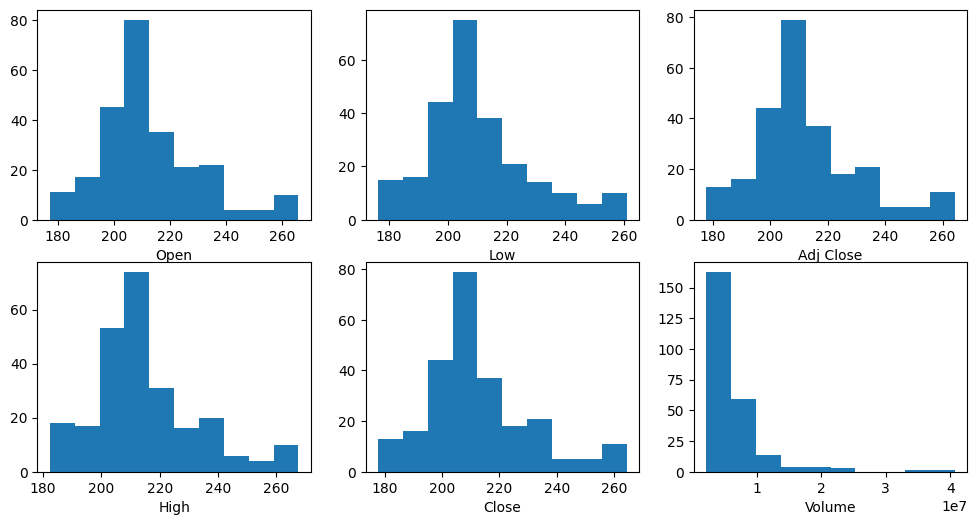

In [4]:
fig,ax = plt.subplots(2,3,figsize=(12,6))
j=0
h=0
for i in range(6):
    ax[j,h].hist(testdata.iloc[:,i])
    ax[j,h].set_xlabel(testdata.columns[i])
  
    if j == 1:
        h += 1
        j = 0
    else:
        j +=1
plt.show()

As expected, the data is clean and regimented. All the price metrics have a normal distribution. The volume metric has a gamma or exponential distribution. We can change the testdata function to test any stock we like. Moving on...

Before we build the model, let's build a better visualizer and a function to preprocess data for the ensuing model.

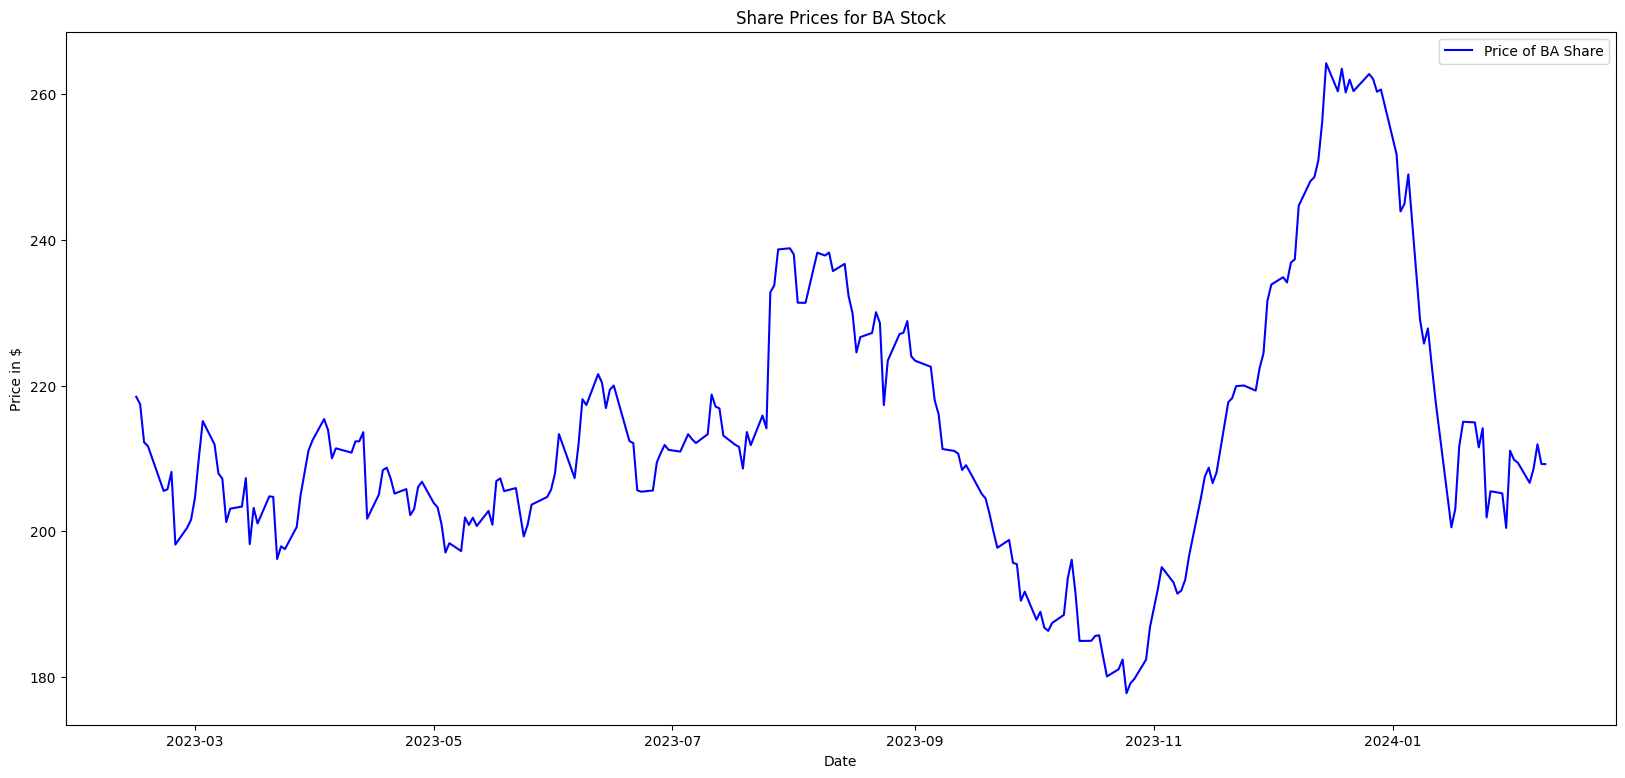

In [5]:
# function to visualize the extracted closing price data
def Visualize_Data(df, Stock,  figsize = (20,9)):
    #plt.style.use(style='ggplot')
    plt.figure(figsize=figsize)
    plt.plot(df['Close'],color='b')
    plt.xlabel('Date')
    plt.ylabel('Price in $')
    plt.legend([f'Price of {Stock} Share'])
    plt.title(f'Share Prices for {Stock} Stock')
    plt.show()

#test the visualizer
Visualize_Data(testdata, 'BA')


In [6]:
#set scaler as a global variable to access inside of the function and outside later...
global scaler
scaler = RobustScaler()

# Function to process data set for training
def Prepare_Data(dataframe, days, stepper):
    # copy the dataframe before we play with it
    df = dataframe.copy()
    
    # Cleave off the number of days to predict from bottom of dataframe
    df = df.iloc[:(df.shape[0]-stepper+1),:]
    # print(df.shape)
    
    # Pre-process the DataFrame
    df = df.drop(['Open', 'High', 'Low', 'Adj Close',  'Volume'], axis=1)
    df['date'] = df.index
    df.dropna(inplace=True)  
    
    # use global scaler function to fit between 0 and 1
    df['scaled_close'] = scaler.fit_transform(np.expand_dims(df['Close'].values, axis=1))
    #print(df.scaled_close)
    
    # Engineer the DataFrame, shift the close price down a day...
    df['future'] = df['scaled_close'].shift(-1)

    #print(len(df.future))
    last_sequence = np.array(df[['scaled_close']].tail(days))

    # Define Variables for sequencing
    sequence_data = []
    targets = []
    sequences = deque(maxlen=days) 
    
    # Generate arrays of close data and dates up to the last sequence...
    for entry, target in zip(df[['scaled_close','date']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == days and target > 0 :
            sequence_data.append(np.array(sequences))
            targets.append(target)
    
    # Modify last sequence to array 
    last_sequence = np.array(last_sequence)

    # build X and Y training lists, converted to numpy arrays for compatibility
    X = np.array(sequence_data)
    Y = np.array(targets)

    return last_sequence, X, Y

# Test the preprocessor and view shapes to ensure they add up...
a, b = 12,1
te = 252 -  1 + b
print("Test days:",te)
tested = Prepare_Data(testdata,a,b)
print("last_sequence",tested[0].shape,"\n X:",tested[1].shape,"\n Y:",tested[2].shape, "\nTotal Days Match:", tested[0].shape[0]+tested[1].shape[0]-a == te )
#tested[1]

Test days: 252
last_sequence (12, 1) 
 X: (119, 12, 2) 
 Y: (119,) 
Total Days Match: False


Great. With data at the ready, we can move on to building the Models, Training, etc.

# Build LSTM Model

To begin, we'll define a function to build a simple Sequential model with 2 layers of LSTM and Dropout that returns a single value. We'll build the function with loss, optimizer, epoch, and batch size inputs to iterate through several options and record results easily.

In [7]:

def Train_Model(x_train, y_train, SEQUENCE_LENGTH, BATCH_SIZE, UNITS, EPOCHS, DROPOUT, OPTIMIZER, LOSS):

    model = Sequential([
        Input(shape=(SEQUENCE_LENGTH,1),batch_size= BATCH_SIZE),
        LSTM(UNITS, return_sequences=True),  
        # Other things that were tried... use_bias=True,stateful=True, recurrent_initializer='orthogonal'),
        Dropout(DROPOUT),
        LSTM(UNITS, return_sequences=False),
        Dropout(DROPOUT),
        Dense(1)
        ])
    model.summary()
    model.compile(loss=LOSS, optimizer=OPTIMIZER)
    model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)


    return model

[*********************100%%**********************]  1 of 1 completed


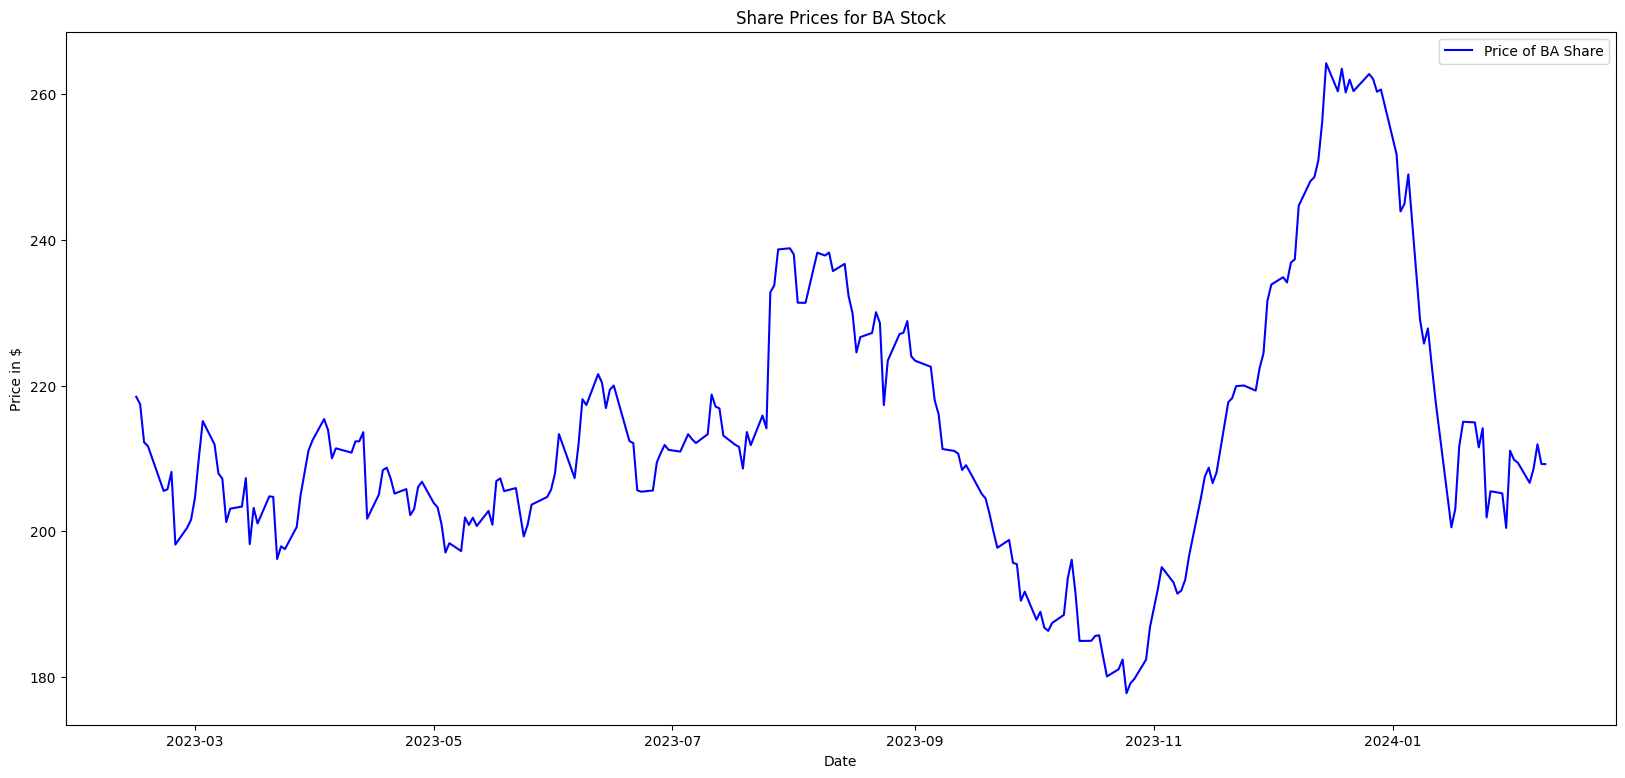

In [8]:
# Define the Stock to model, and YFinance pull characteristics
STOCK = 'BA' #  ticker symbol 
LENGTH = 12 # Length of the extracted data in months
INTERVAL = '1d' # Interval (see options above)
PREDICTION_STEPS = 5 # Number of int(days) the model(s) will predict. 
# To predict the next three days change to 3.

#Set Variable Parameters/Hyperparameters
if INTERVAL == '4h':
    SEQUENCE_LENGTH = 30 * 2 # Number of days * 3 times per day that the model will be trained 
elif INTERVAL == '1h':
    SEQUENCE_LENGTH = 30 * 2 # Number of days * 7 hrs per day that the model will be trained 
else: # INTERVAL == '1d'
    SEQUENCE_LENGTH = 30  # Number of days back that the model will be trained   

# Visualize Data
raw_price_df = Extract_Data(Stock = STOCK, intervalmos = LENGTH,interval =    INTERVAL )
Visualize_Data(raw_price_df, Stock = STOCK, )


In [9]:
# Inspect dates before modeling...
raw_price_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-14,214.020004,221.330002,213.149994,218.449997,218.449997,10033100
2023-02-15,217.160004,218.250000,214.600006,217.440002,217.440002,4846800
2023-02-16,215.000000,216.520004,212.169998,212.210007,212.210007,4388000
2023-02-17,211.210007,211.759995,207.619995,211.660004,211.660004,4985700
2023-02-21,208.990005,210.839996,205.050003,205.520004,205.520004,4663800
...,...,...,...,...,...,...
2024-02-05,204.639999,207.339996,202.000000,206.630005,206.630005,8682500
2024-02-06,206.020004,210.639999,203.889999,208.580002,208.580002,7556900
2024-02-07,208.759995,213.770004,207.990005,211.919998,211.919998,7747700


Now that we have stock data to model, a modeling function, and can see it, we define parameters for the first model and see what we get.

In [10]:
#Set Constant Parameters/Hyperparameters
BATCH_SIZE = 25 
DROPOUT = 0.25 # regularization  
UNITS = 60 # Number of neurons  
EPOCHS = 10  
LOSS='mean_squared_error' # Loss Function
OPTIMIZER='adam' 

# Make Prediction
predictions = []

for step in range(PREDICTION_STEPS):
    stepped = PREDICTION_STEPS - step
    last_sequence, x_train, y_train = Prepare_Data(raw_price_df, SEQUENCE_LENGTH, stepped)
    #print("Sequence Pull Shape:",last_sequence.shape)
    x_train = x_train[:, :, :1].astype(np.float32)

    model = Train_Model(x_train, y_train, SEQUENCE_LENGTH, BATCH_SIZE, UNITS, EPOCHS, DROPOUT, OPTIMIZER, LOSS)

    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]
    predictions.append(round(float(predicted_price), 2))
    
# Print Predictions
if len(predictions) > 0:
    predictions_list = ['$'+str(p) for p in predictions]
    predictions_str = ', '.join(predictions_list)
    message = f'{STOCK} share price prediction(s) for next {len(predictions)} day(s) {predictions_str}'
    print(message)

LSTMdf = pd.DataFrame({"Date":list(raw_price_df.index)[-PREDICTION_STEPS:],
                       "Actual Close":[round(x,2) for x in list(raw_price_df.Close.tail(PREDICTION_STEPS).values)],
                       "Predicted Close":predictions 
                       })
LSTMdf['Difference'] = [round(x,2) for x in np.array(LSTMdf['Actual Close']).astype(float)-predictions]
LSTMdf["Model"] = 'LSTM'
LSTMdf["Optimizer"] = "Adam"
LSTMdf["Batch Size"] = BATCH_SIZE

LSTMdf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (25, 30, 60)              14880     
                                                                 
 dropout (Dropout)           (25, 30, 60)              0         
                                                                 
 lstm_1 (LSTM)               (25, 60)                  29040     
                                                                 
 dropout_1 (Dropout)         (25, 60)                  0         
                                                                 
 dense (Dense)               (25, 1)                   61        
                                                                 
Total params: 43981 (171.80 KB)
Trainable params: 43981 (171.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [=============

,Date,Actual Close,Predicted Close,Difference,Model,Optimizer,Batch Size
0,2024-02-05,206.63,208.05,-1.42,LSTM,Adam,25
1,2024-02-06,208.58,207.62,0.96,LSTM,Adam,25
2,2024-02-07,211.92,210.08,1.84,LSTM,Adam,25
3,2024-02-08,209.22,210.79,-1.57,LSTM,Adam,25
4,2024-02-09,209.20,211.10,-1.90,LSTM,Adam,25


In [11]:

#Set Constant Parameters/Hyperparameters
BATCH_SIZE = 15
DROPOUT = 0.25 # Regularization  
UNITS = 60 # Number of neurons  
EPOCHS = 10  
LOSS='mean_squared_error' # Loss Function 
OPTIMIZER='RMSprop' # Optimizer 

# Make Prediction
predictions = []

for step in range(PREDICTION_STEPS):
    stepped = PREDICTION_STEPS - step
    last_sequence, x_train, y_train = Prepare_Data(raw_price_df, SEQUENCE_LENGTH, stepped)
    x_train = x_train[:, :, :1].astype(np.float32)
    model = Train_Model(x_train, y_train, SEQUENCE_LENGTH, BATCH_SIZE, UNITS, EPOCHS, DROPOUT, OPTIMIZER, LOSS)
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]
    predictions.append(round(float(predicted_price), 2))
    
# Print Predictions
if len(predictions) > 0:
    predictions_list = ['$'+str(p) for p in predictions]
    predictions_str = ', '.join(predictions_list)
    message = f'{STOCK} share price prediction(s) for next {len(predictions)} day(s) {predictions_str}'
    print(message)

LSTM2df = pd.DataFrame({"Date":list(raw_price_df.index)[-PREDICTION_STEPS:],
                       "Actual Close":[round(x,2) for x in list(raw_price_df.Close.tail(PREDICTION_STEPS).values)],
                       "Predicted Close":predictions
                       })
LSTM2df['Difference'] = [round(x,2) for x in np.array(LSTMdf['Actual Close']).astype(float)-predictions]
LSTM2df["Model"] = 'LSTM'
LSTM2df["Optimizer"] = OPTIMIZER
LSTM2df["Batch Size"] = BATCH_SIZE

LSTM2df

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (15, 30, 60)              14880     
                                                                 
 dropout_10 (Dropout)        (15, 30, 60)              0         
                                                                 
 lstm_11 (LSTM)              (15, 60)                  29040     
                                                                 
 dropout_11 (Dropout)        (15, 60)                  0         
                                                                 
 dense_5 (Dense)             (15, 1)                   61        
                                                                 
Total params: 43981 (171.80 KB)
Trainable params: 43981 (171.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [===========

,Date,Actual Close,Predicted Close,Difference,Model,Optimizer,Batch Size
0,2024-02-05,206.63,208.96,-2.33,LSTM,RMSprop,15
1,2024-02-06,208.58,206.27,2.31,LSTM,RMSprop,15
2,2024-02-07,211.92,209.82,2.10,LSTM,RMSprop,15
3,2024-02-08,209.22,209.68,-0.46,LSTM,RMSprop,15
4,2024-02-09,209.20,210.29,-1.09,LSTM,RMSprop,15


In [12]:
#Set Constant Parameters/Hyperparameters
BATCH_SIZE = 12  
DROPOUT = 0.25 # Regularization  
UNITS = 60 # Number of neurons in each layer
EPOCHS = 10 
LOSS='mean_squared_error' # Loss Function 
OPTIMIZER='SGD' # Optimizer 

# Make Prediction
predictions = []

for step in range(PREDICTION_STEPS):
    stepped = PREDICTION_STEPS - step
    last_sequence, x_train, y_train = Prepare_Data(raw_price_df, SEQUENCE_LENGTH, stepped)
    x_train = x_train[:, :, :1].astype(np.float32)
    model = Train_Model(x_train, y_train, SEQUENCE_LENGTH, BATCH_SIZE, UNITS, EPOCHS, DROPOUT, OPTIMIZER, LOSS)
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]
    predictions.append(round(float(predicted_price), 2))
    
# Print Predictions
if len(predictions) > 0:
    predictions_list = ['$'+str(p) for p in predictions]
    predictions_str = ', '.join(predictions_list)
    message = f'{STOCK} share price prediction(s) for next {len(predictions)} day(s) {predictions_str}'
    print(message)

LSTM3df = pd.DataFrame({"Date":list(raw_price_df.index)[-PREDICTION_STEPS:],
                       "Actual Close":[round(x,2) for x in list(raw_price_df.Close.tail(PREDICTION_STEPS).values)],
                       "Predicted Close":predictions
                       })
LSTM3df['Difference'] = [round(x,2) for x in np.array(LSTMdf['Actual Close']).astype(float)-predictions]
LSTM3df["Model"] = 'LSTM'
LSTM3df["Optimizer"] = OPTIMIZER
LSTM3df["Batch Size"] = BATCH_SIZE

LSTM3df

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (12, 30, 60)              14880     
                                                                 
 dropout_20 (Dropout)        (12, 30, 60)              0         
                                                                 
 lstm_21 (LSTM)              (12, 60)                  29040     
                                                                 
 dropout_21 (Dropout)        (12, 60)                  0         
                                                                 
 dense_10 (Dense)            (12, 1)                   61        
                                                                 
Total params: 43981 (171.80 KB)
Trainable params: 43981 (171.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==========

,Date,Actual Close,Predicted Close,Difference,Model,Optimizer,Batch Size
0,2024-02-05,206.63,213.19,-6.56,LSTM,SGD,12
1,2024-02-06,208.58,215.55,-6.97,LSTM,SGD,12
2,2024-02-07,211.92,215.61,-3.69,LSTM,SGD,12
3,2024-02-08,209.22,215.04,-5.82,LSTM,SGD,12
4,2024-02-09,209.20,215.15,-5.95,LSTM,SGD,12


In [13]:
LSTMav = round(np.mean(LSTMdf.Difference),3)
LSTM2av = round(np.mean(LSTM2df.Difference),3)
LSTM3av = round(np.mean(LSTM3df.Difference),3)
print(f"Averages: LSTM with Adam Optimizer: {LSTMav}  -  LSTM with RMSprop Optimizer: {LSTM2av}  - LSTM with SGD Optimizer: {LSTM3av}")
LSTout = pd.concat([LSTMdf,LSTM2df,LSTM3df]) 
LSTout

Averages: LSTM with Adam Optimizer: -0.418  -  LSTM with RMSprop Optimizer: 0.106  - LSTM with SGD Optimizer: -5.798


,Date,Actual Close,Predicted Close,Difference,Model,Optimizer,Batch Size
0,2024-02-05,206.63,208.05,-1.42,LSTM,Adam,25
1,2024-02-06,208.58,207.62,0.96,LSTM,Adam,25
2,2024-02-07,211.92,210.08,1.84,LSTM,Adam,25
3,2024-02-08,209.22,210.79,-1.57,LSTM,Adam,25
4,2024-02-09,209.20,211.10,-1.90,LSTM,Adam,25
0,2024-02-05,206.63,208.96,-2.33,LSTM,RMSprop,15
1,2024-02-06,208.58,206.27,2.31,LSTM,RMSprop,15
2,2024-02-07,211.92,209.82,2.10,LSTM,RMSprop,15
3,2024-02-08,209.22,209.68,-0.46,LSTM,RMSprop,15
4,2024-02-09,209.20,210.29,-1.09,LSTM,RMSprop,15


# Build GRU Model


In [14]:
def Train_ModelG(x_train, y_train, SEQUENCE_LENGTH, BATCH_SIZE, UNITS, EPOCHS, DROPOUT, OPTIMIZER, LOSS):

    model = Sequential([
        Input(shape=(SEQUENCE_LENGTH,1),batch_size= BATCH_SIZE),
        GRU(UNITS, return_sequences=True), # use_bias=True,stateful=True, recurrent_initializer='orthogonal'),
        Dropout(DROPOUT),
        GRU(UNITS, return_sequences=False),
        Dropout(DROPOUT),
        Dense(1)
        ])
    model.summary()
    model.compile(loss=LOSS, optimizer=OPTIMIZER)
    model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    return model

In [15]:
#Set Constant Parameters/Hyperparameters
BATCH_SIZE = 25  
DROPOUT = 0.25 # Regularization  
UNITS = 60 # Number of GRU neurons per layer
EPOCHS = 10  
LOSS='mean_squared_error' # Loss Function 
OPTIMIZER='adam' # Optimizer 

# Make Prediction
predictions = []

for step in range(PREDICTION_STEPS):
    stepped = PREDICTION_STEPS - step
    last_sequence, x_train, y_train = Prepare_Data(raw_price_df, SEQUENCE_LENGTH, stepped) 
    x_train = x_train[:, :, :1].astype(np.float32)
    modelg = Train_ModelG(x_train, y_train, SEQUENCE_LENGTH, BATCH_SIZE, UNITS, EPOCHS, DROPOUT, OPTIMIZER, LOSS)
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = modelg.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]
    predictions.append(round(float(predicted_price), 2))
    
# Print Predictions
if len(predictions) > 0:
    predictions_list = ['$'+str(p) for p in predictions]
    predictions_str = ', '.join(predictions_list)
    message = f'{STOCK} share price prediction(s) for next {len(predictions)} day(s) {predictions_str}'
    print(message)

GRUdf = pd.DataFrame({"Date":list(raw_price_df.index)[-PREDICTION_STEPS:],
                       "Actual Close":[round(x,2) for x in list(raw_price_df.Close.tail(PREDICTION_STEPS).values)],
                       "Predicted Close":predictions
                       })
GRUdf['Difference'] = [round(x,2) for x in np.array(LSTMdf['Actual Close']).astype(float)-predictions]
GRUdf["Model"] = 'GRU'
GRUdf["Optimizer"] = OPTIMIZER
GRUdf["Batch Size"] = BATCH_SIZE

GRUdf

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (25, 30, 60)              11340     
                                                                 
 dropout_30 (Dropout)        (25, 30, 60)              0         
                                                                 
 gru_1 (GRU)                 (25, 60)                  21960     
                                                                 
 dropout_31 (Dropout)        (25, 60)                  0         
                                                                 
 dense_15 (Dense)            (25, 1)                   61        
                                                                 
Total params: 33361 (130.32 KB)
Trainable params: 33361 (130.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==========

,Date,Actual Close,Predicted Close,Difference,Model,Optimizer,Batch Size
0,2024-02-05,206.63,211.48,-4.85,GRU,adam,25
1,2024-02-06,208.58,211.45,-2.87,GRU,adam,25
2,2024-02-07,211.92,212.94,-1.02,GRU,adam,25
3,2024-02-08,209.22,212.57,-3.35,GRU,adam,25
4,2024-02-09,209.20,212.59,-3.39,GRU,adam,25


In [16]:
#Set Constant Parameters/Hyperparameters
BATCH_SIZE = 15 
DROPOUT = 0.25 # Regularization  
UNITS = 60 # Number of GRU neurons per layer
EPOCHS = 10  
LOSS='mean_squared_error' # Loss Function 
OPTIMIZER='RMSprop' 

# Make Prediction
predictions = []

for step in range(PREDICTION_STEPS):
    stepped = PREDICTION_STEPS - step
    last_sequence, x_train, y_train = Prepare_Data(raw_price_df, SEQUENCE_LENGTH, stepped)
    x_train = x_train[:, :, :1].astype(np.float32)
    modelg = Train_ModelG(x_train, y_train, SEQUENCE_LENGTH, BATCH_SIZE, UNITS, EPOCHS, DROPOUT, OPTIMIZER, LOSS)
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = modelg.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]
    predictions.append(round(float(predicted_price), 2))
    
# Print Predictions
if len(predictions) > 0:
    predictions_list = ['$'+str(p) for p in predictions]
    predictions_str = ', '.join(predictions_list)
    message = f'{STOCK} share price prediction(s) for next {len(predictions)} day(s) {predictions_str}'
    print(message)

GRU2df = pd.DataFrame({"Date":list(raw_price_df.index)[-PREDICTION_STEPS:],
                       "Actual Close":[round(x,2) for x in list(raw_price_df.Close.tail(PREDICTION_STEPS).values)],
                       "Predicted Close":predictions
                       })
GRU2df['Difference'] = [round(x,2) for x in np.array(LSTMdf['Actual Close']).astype(float)-predictions]
GRU2df["Model"] = 'GRU'
GRU2df["Optimizer"] = OPTIMIZER
GRU2df["Batch Size"] = BATCH_SIZE

GRU2df

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (15, 30, 60)              11340     
                                                                 
 dropout_40 (Dropout)        (15, 30, 60)              0         
                                                                 
 gru_11 (GRU)                (15, 60)                  21960     
                                                                 
 dropout_41 (Dropout)        (15, 60)                  0         
                                                                 
 dense_20 (Dense)            (15, 1)                   61        
                                                                 
Total params: 33361 (130.32 KB)
Trainable params: 33361 (130.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==========

,Date,Actual Close,Predicted Close,Difference,Model,Optimizer,Batch Size
0,2024-02-05,206.63,211.08,-4.45,GRU,RMSprop,15
1,2024-02-06,208.58,211.15,-2.57,GRU,RMSprop,15
2,2024-02-07,211.92,213.27,-1.35,GRU,RMSprop,15
3,2024-02-08,209.22,212.01,-2.79,GRU,RMSprop,15
4,2024-02-09,209.20,212.46,-3.26,GRU,RMSprop,15


In [17]:
#Set Constant Parameters/Hyperparameters
BATCH_SIZE = 12  
DROPOUT = 0.25 # Regularization  
UNITS = 60 # Number of GRU neurons per layer
EPOCHS = 10  
LOSS='mean_squared_error' # Loss Function 
OPTIMIZER='SGD'  

# Make Prediction
predictions = []

for step in range(PREDICTION_STEPS):
    stepped = PREDICTION_STEPS - step
    last_sequence, x_train, y_train = Prepare_Data(raw_price_df, SEQUENCE_LENGTH, stepped)
    x_train = x_train[:, :, :1].astype(np.float32)
    modelg = Train_ModelG(x_train, y_train, SEQUENCE_LENGTH, BATCH_SIZE, UNITS, EPOCHS, DROPOUT, OPTIMIZER, LOSS)
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = modelg.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]
    predictions.append(round(float(predicted_price), 2))
    
# Print Predictions
if len(predictions) > 0:
    predictions_list = ['$'+str(p) for p in predictions]
    predictions_str = ', '.join(predictions_list)
    message = f'{STOCK} share price prediction(s) for next {len(predictions)} day(s) {predictions_str}'
    print(message)

GRU3df = pd.DataFrame({"Date":list(raw_price_df.index)[-PREDICTION_STEPS:],
                       "Actual Close":[round(x,2) for x in list(raw_price_df.Close.tail(PREDICTION_STEPS).values)],
                       "Predicted Close":predictions
                       })
GRU3df['Difference'] = [round(x,2) for x in np.array(LSTMdf['Actual Close']).astype(float)-predictions]
GRU3df["Model"] = 'GRU'
GRU3df["Optimizer"] = OPTIMIZER
GRU3df["Batch Size"] = BATCH_SIZE

GRU3df

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_20 (GRU)                (12, 30, 60)              11340     
                                                                 
 dropout_50 (Dropout)        (12, 30, 60)              0         
                                                                 
 gru_21 (GRU)                (12, 60)                  21960     
                                                                 
 dropout_51 (Dropout)        (12, 60)                  0         
                                                                 
 dense_25 (Dense)            (12, 1)                   61        
                                                                 
Total params: 33361 (130.32 KB)
Trainable params: 33361 (130.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==========

,Date,Actual Close,Predicted Close,Difference,Model,Optimizer,Batch Size
0,2024-02-05,206.63,211.71,-5.08,GRU,SGD,12
1,2024-02-06,208.58,211.36,-2.78,GRU,SGD,12
2,2024-02-07,211.92,212.17,-0.25,GRU,SGD,12
3,2024-02-08,209.22,212.48,-3.26,GRU,SGD,12
4,2024-02-09,209.20,211.99,-2.79,GRU,SGD,12


In [18]:
GRUav = round(np.mean(GRUdf.Difference),4)
GRU2av = round(np.mean(GRU2df.Difference),4)
GRU3av = round(np.mean(GRU3df.Difference),4)
print(f"Averages: GRU with Adam Optimizer: {GRUav}  -  GRU with RMSprop Optimizer: {GRU2av}  - GRU with SGD Optimizer: {GRU3av}")
GRUout = pd.concat([GRUdf,GRU2df,GRU3df]) 
GRUout

Averages: GRU with Adam Optimizer: -3.096  -  GRU with RMSprop Optimizer: -2.884  - GRU with SGD Optimizer: -2.832


,Date,Actual Close,Predicted Close,Difference,Model,Optimizer,Batch Size
0,2024-02-05,206.63,211.48,-4.85,GRU,adam,25
1,2024-02-06,208.58,211.45,-2.87,GRU,adam,25
2,2024-02-07,211.92,212.94,-1.02,GRU,adam,25
3,2024-02-08,209.22,212.57,-3.35,GRU,adam,25
4,2024-02-09,209.20,212.59,-3.39,GRU,adam,25
0,2024-02-05,206.63,211.08,-4.45,GRU,RMSprop,15
1,2024-02-06,208.58,211.15,-2.57,GRU,RMSprop,15
2,2024-02-07,211.92,213.27,-1.35,GRU,RMSprop,15
3,2024-02-08,209.22,212.01,-2.79,GRU,RMSprop,15
4,2024-02-09,209.20,212.46,-3.26,GRU,RMSprop,15


# Results and Visualization

Now that we have data from 2 models, and tree optimers for each, let's plot that data against actual closing price for the stock for the number of days.

In [19]:
allout = pd.concat([LSTout,GRUout])
allout

,Date,Actual Close,Predicted Close,Difference,Model,Optimizer,Batch Size
0,2024-02-05,206.63,208.05,-1.42,LSTM,Adam,25
1,2024-02-06,208.58,207.62,0.96,LSTM,Adam,25
2,2024-02-07,211.92,210.08,1.84,LSTM,Adam,25
3,2024-02-08,209.22,210.79,-1.57,LSTM,Adam,25
4,2024-02-09,209.20,211.10,-1.90,LSTM,Adam,25
0,2024-02-05,206.63,208.96,-2.33,LSTM,RMSprop,15
1,2024-02-06,208.58,206.27,2.31,LSTM,RMSprop,15
2,2024-02-07,211.92,209.82,2.10,LSTM,RMSprop,15
3,2024-02-08,209.22,209.68,-0.46,LSTM,RMSprop,15
4,2024-02-09,209.20,210.29,-1.09,LSTM,RMSprop,15


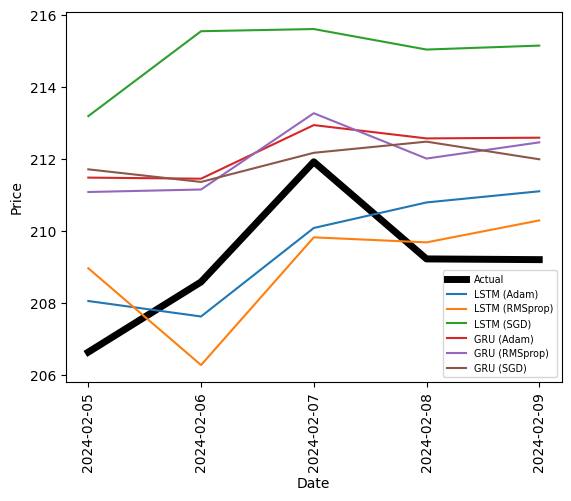

In [20]:
plt.plot(raw_price_df.index.tolist()[-PREDICTION_STEPS:],
         raw_price_df.Close.tail(PREDICTION_STEPS),
         lw=5,
         color='black')
plt.plot(LSTMdf.Date,LSTMdf['Predicted Close'])
plt.plot(LSTM2df.Date,LSTM2df['Predicted Close'])
plt.plot(LSTM3df.Date,LSTM3df['Predicted Close'])
plt.plot(GRUdf.Date,GRUdf['Predicted Close'])
plt.plot(GRU2df.Date,GRU2df['Predicted Close'])
plt.plot(GRU3df.Date,GRU3df['Predicted Close'])
plt.xlabel("Date")
plt.ylabel('Price')
plt.xticks(minor=False)
plt.xticks(ticks= LSTMdf.Date, rotation="vertical")
plt.legend(['Actual','LSTM (Adam)','LSTM (RMSprop)','LSTM (SGD)','GRU (Adam)', 'GRU (RMSprop)', 'GRU (SGD)'], 
           fontsize='x-small')
plt.show()



# Conclusion

This notebook shows that a large bit of the variation in a stock's price can indeed be modeled by recurrent neural networks with LSTM or GRU units. Some other interesting things in this notebook are to include the visual confirmation of the affect optimizers play in these models. The variation in the models isn't as uniform as the variation in the optimizers. For instance, the green and brown lines in the plot above mimic each other and are both SGD optimizer (one using LSTM model and one using GRU). The same can be gleaned from the orange and purple lines which are both RMSprop optimizer.

 Results: there wasn't an earnings release or other news this week that would have adversely affected these models. Stock patterns are only a portion of the underlying stock pricing mechanisms. Please don't use this model to automate trading as the yfinance package is unsupported.

I feel that by tuning the hyperparameters of the models and optimizers. Doing so could lead to increased accuracy. Other things that deserve attention in future iterations include tuning the batch sizes, playing with the interval (1min, 1hour, 1day) market data sequences, and the models themselves (varying the number of layers and units).
